In [8]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from os import pardir
from tqdm import tqdm

In [9]:
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [10]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [11]:
from utils import safe_mkdir, nu_mod, fzw

In [12]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir 

'/home2/s20321005/Thesis-Project/Data'

In [13]:
name = "Baryon"
data_dir = join(root_data_dir, name)
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#    components               rho     e_rho    sigma_z    e_sigma_z
0    Molecular gas (H2)       0.0104  0.00312  3.7        0.2
1    Cold atomic gas (HI(1))  0.0277  0.00554  7.1        0.5
2    Warm atomic gas (HI(2))  0.0073  0.0007   22.1       2.4
3    Hot ionized gas (HII)    0.0005  3e-05    39.0       4.0
4    Giant stars              0.0006  6e-05    15.5       1.6
...  ...                      ...     ...      ...        ...
7    4 < MV < 5               0.0029  0.00029  18.0       1.8
8    5 < MV < 8               0.0072  0.00072  18.5       1.9
9    MV > 8                   0.0216  0.0028   18.5       4.0
10   White dwarfs             0.0056  0.001    20.0       5.0
11   Brown dwarfs             0.0015  0.0005   20.0       5.0

In [7]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 0 # Msun/pc^2
hDD = 1 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = 0
sigma_w = np.array([10])
a_raw = np.array([1])
w0 = np.array([-7])

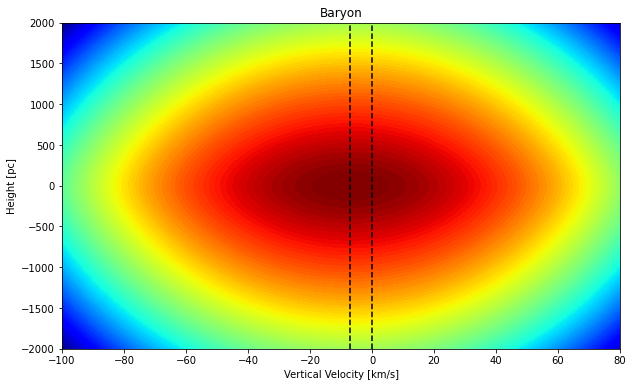

In [264]:
z = np.linspace(-2000, 2000, 300)
w = np.linspace(-100, 80, 200)

W, Z = np.meshgrid(w, z)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

FZW = fzw(Z, W, **theta)

plt.figure(figsize=(10, 6))
plt.contourf(W, Z, np.log(FZW), 100, cmap="jet")
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Height [pc]")
plt.axvline(w0[0], c="k", ls="--")
plt.axvline(0, c="k", ls="--")
plt.title(name)
plt.show()

In [15]:
def plot_chain(samples, labels, figsize=(10, 7), alpha=0.3, start=0):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[start:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples[start:, :, i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")

In [16]:
# hide warning
import warnings
warnings.filterwarnings("ignore")

In [17]:
def log_prob(th):
    z, w = th
    return np.log(fzw(z, w, **theta))

In [268]:
log_prob([0.2, -7])

-3.2215236261987186

100%|██████████| 1000/1000 [00:25<00:00, 39.56it/s]


Multiprocessing took 25.3 seconds


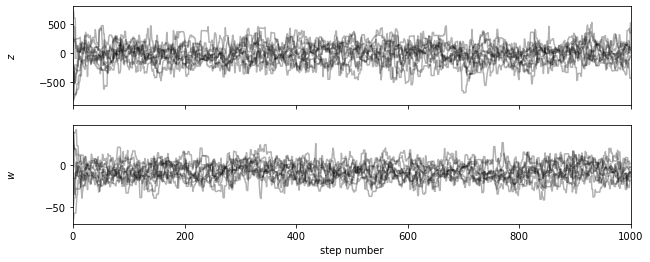

In [269]:
import emcee
import os
from multiprocessing import Pool
from time import time

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

ndim = 2
nwalkers = 10
z_0 = np.random.uniform(-1000, 1000, nwalkers)
w_0 = np.random.uniform(-70, 70, nwalkers)
p0 = np.array([z_0, w_0]).T

labels = [r"$z$", r"$w$"]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_prob, 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(p0, 1000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,4))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 2000/2000 [00:49<00:00, 40.12it/s]


Multiprocessing took 49.9 seconds


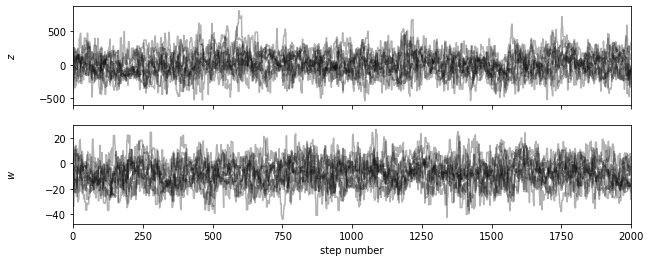

In [106]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_prob, 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,4))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

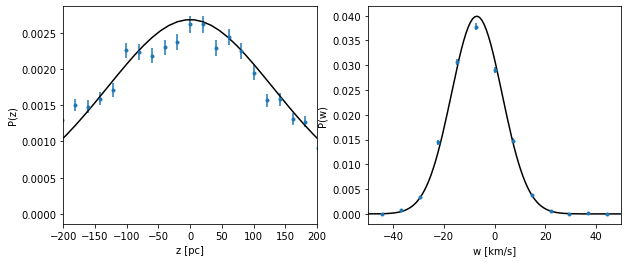

In [270]:
flat_samples = sampler_.get_chain(flat=True)
zs = flat_samples[:, 0]
ws = flat_samples[:, 1]

zbound = 200
wbound = 50

zedges = np.linspace(-1000, 1000, 100)
wedges = np.linspace(-70, 70, 20)

znum, _ = np.histogram(zs, bins=zedges)
wnum, _ = np.histogram(ws, bins=wedges)
zerr = np.sqrt(znum)
werr = np.sqrt(wnum)

zmid = (zedges[1:] + zedges[:-1]) / 2
wmid = (wedges[1:] + wedges[:-1]) / 2

areaz = np.trapz(znum, zmid)
areaw = np.trapz(wnum, wmid)

Fz = np.trapz(FZW, w, axis=1)
area = np.trapz(Fz, z)
Fz /= area
Fw = np.trapz(FZW, z, axis=0)
Fw /= area

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].errorbar(zmid, znum/areaz, yerr=zerr/areaz, fmt=".")
axes[0].plot(z, Fz, c="k")
axes[0].set_xlim(-zbound, zbound)
axes[0].set_xlabel("z [pc]")
axes[0].set_ylabel("P(z)")
axes[1].errorbar(wmid, wnum/areaw, yerr=werr/areaw, fmt=".")
axes[1].plot(w, Fw, c="k")
axes[1].set_xlim(-wbound, wbound)
axes[1].set_xlabel("w [km/s]")
axes[1].set_ylabel("P(w)")
plt.show()

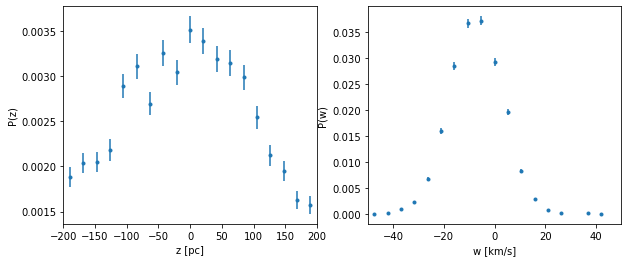

In [271]:
zedges = np.linspace(-zbound, zbound, 20)
wedges = np.linspace(-wbound, wbound, 20)

zss = zs[(zs>-zbound) * (zs<zbound)]
wss = ws[(ws>-wbound) * (ws<wbound)]

znum, _ = np.histogram(zss, bins=zedges)
wnum, _ = np.histogram(wss, bins=wedges)
zerr = np.sqrt(znum)
werr = np.sqrt(wnum)

zmid = (zedges[1:] + zedges[:-1]) / 2
wmid = (wedges[1:] + wedges[:-1]) / 2

areaw = np.trapz(wnum, wmid)
areaz = np.trapz(znum, zmid)

zdens, wdens = znum/areaz, wnum/areaw
zerr, werr = zerr/areaz, werr/areaw

maskz = zdens>0
maskw = wdens>0

zdens, zerr, zmid = zdens[maskz], zerr[maskz], zmid[maskz]
wdens, werr, wmid = wdens[maskw], werr[maskw], wmid[maskw]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt=".")
axes[0].set_xlim(-zbound, zbound)
axes[0].set_xlabel("z [pc]")
axes[0].set_ylabel("P(z)")
axes[1].errorbar(wmid, wdens, yerr=werr, fmt=".")
axes[1].set_xlim(-wbound, wbound)
axes[1].set_xlabel("w [km/s]")
axes[1].set_ylabel("P(w)")
plt.show()

# pretend to fit the data

In [26]:
from scipy.stats import norm, uniform

# prior
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [27]:
from utils import fw

# likelihood
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    res = resz + resw
    if np.isnan(res):
        print("==============")
        print(theta['rhoDM'])
        print("******************")
    return res

In [28]:
# posterior DM only
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf
    
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [322]:
# dm only

theta = [
    -0.05, 
    np.log(0.001), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    rhoDM=-0.08, 
    log_nu0=np.log(0.001), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhoDM=0.1-locs['rhoDM'],
    log_nu0=np.log(0.01)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, 1), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

dim = 1

In [323]:
# run log prior
theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
log_prior(theta_dict, locs, scales, norm_list_DM, uni_list_DM)

2.3793560958203317

In [324]:
theta_dict['sigmaDD'] = 0
theta_dict['hDD'] = 1
theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])

log_likelihood(theta_dict, zdata, wdata)

-1415.0297291316178

In [325]:
theta_dict['rhoDM'] = -0.08

fw(wmid, **theta_dict)

array([1.15384578e-05, 8.40855892e-05, 4.64506928e-04, 1.94517930e-03,
       6.17481432e-03, 1.48588427e-02, 2.71045928e-02, 3.74798296e-02,
       3.92870255e-02, 3.12174560e-02, 1.88036729e-02, 8.58587749e-03,
       2.97182687e-03, 7.79756751e-04, 1.55092787e-04, 2.67268006e-06,
       2.31563385e-07])

In [326]:
log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM)

-1412.6503730357974

In [327]:
theta = np.concatenate([np.ravel(x) for x in locs.values()])

ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list_DM + norm_list_DM
index = 0

rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
p0.shape

(15, 7)

In [329]:
p00 = p0[3]
theta_dict = dict(
    rhoDM=p00[0],
    log_nu0=p00[1],
    zsun=p00[2],
    R=p00[3],
    w0=p00[4:4+dim],
    log_sigma_w=p00[4+dim:4+2*dim],
    a=p00[4+2*dim:4+3*dim]
)

log_prior(theta_dict, locs, scales, norm_list_DM, uni_list_DM)

0.6345574644567293

In [330]:
zdata

(array([-1.89473684e+02, -1.68421053e+02, -1.47368421e+02, -1.26315789e+02,
        -1.05263158e+02, -8.42105263e+01, -6.31578947e+01, -4.21052632e+01,
        -2.10526316e+01,  1.42108547e-14,  2.10526316e+01,  4.21052632e+01,
         6.31578947e+01,  8.42105263e+01,  1.05263158e+02,  1.26315789e+02,
         1.47368421e+02,  1.68421053e+02,  1.89473684e+02]),
 array([0.00188515, 0.00203748, 0.00205018, 0.00218347, 0.00289437,
        0.00311018, 0.0026976 , 0.00325616, 0.0030467 , 0.0035164 ,
        0.00338946, 0.00319269, 0.00314826, 0.00298958, 0.00254527,
        0.00212634, 0.00195497, 0.00163126, 0.00157413]),
 array([1.09387342e-04, 1.13721181e-04, 1.14074903e-04, 1.17724829e-04,
        1.35541182e-04, 1.40503417e-04, 1.30852888e-04, 1.43763133e-04,
        1.39062318e-04, 1.49397637e-04, 1.46676141e-04, 1.42355037e-04,
        1.41361025e-04, 1.37752440e-04, 1.27104531e-04, 1.16174617e-04,
        1.11394617e-04, 1.01754918e-04, 9.99573392e-05]))

In [331]:
for p00 in p0:
    print(log_posterior_simple_DM(p00, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM))

-1121.5767130979432
-615.3914683143367
-1070.029598961084
-6642.605939393348
-15735.965589781215
-4528.50917922629
-172.87912168540757
-2834.2442337659113
-2314.0434616812295
-314.76774826867864
-839.3589696137611
-2525.256062657747
-1946.5717347275058
-5485.48710049576
-1629.8665989640012


100%|██████████| 500/500 [00:31<00:00, 15.67it/s]


Multiprocessing took 32.0 seconds


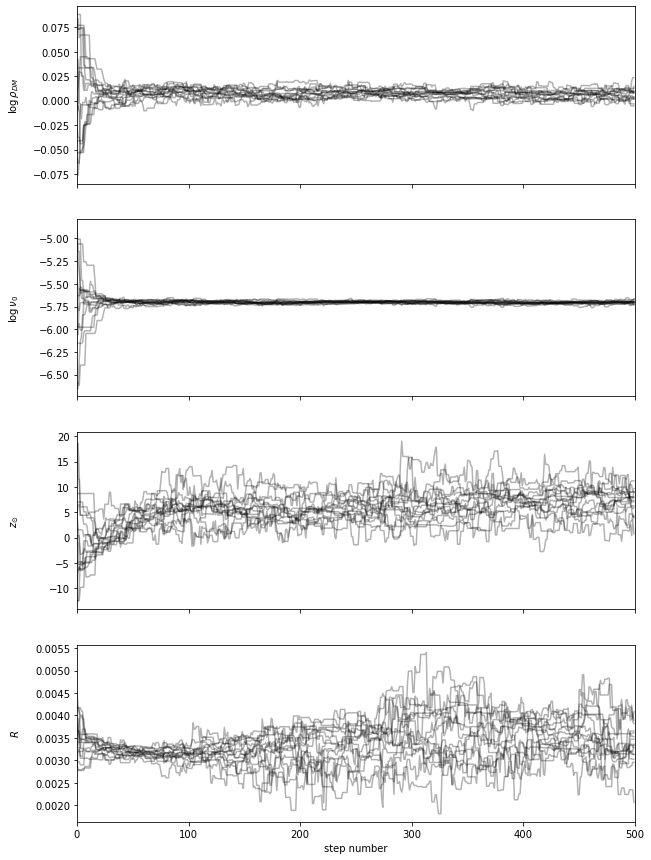

In [332]:
os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 1000/1000 [01:03<00:00, 15.79it/s]


Multiprocessing took 63.5 seconds


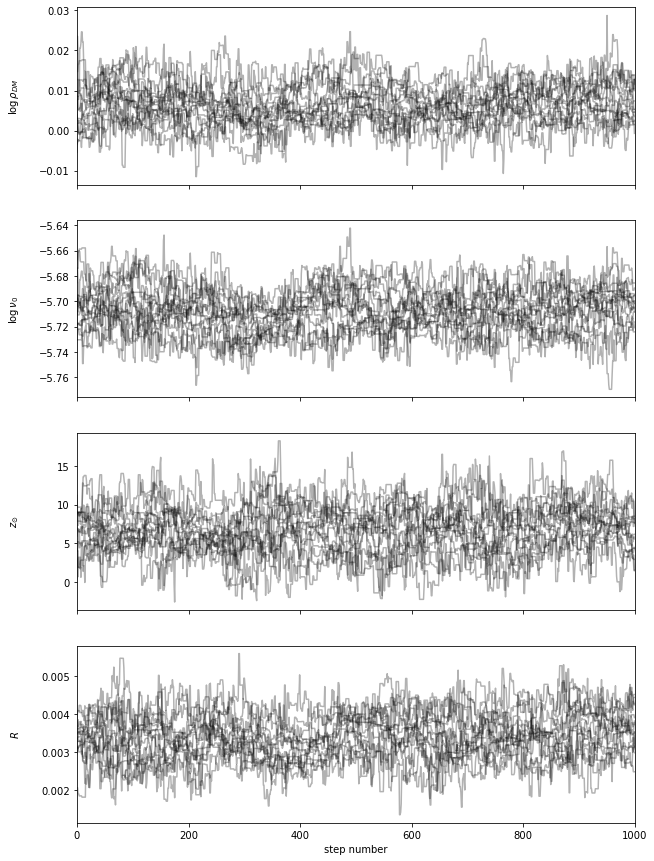

In [333]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(next_p0, 1000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

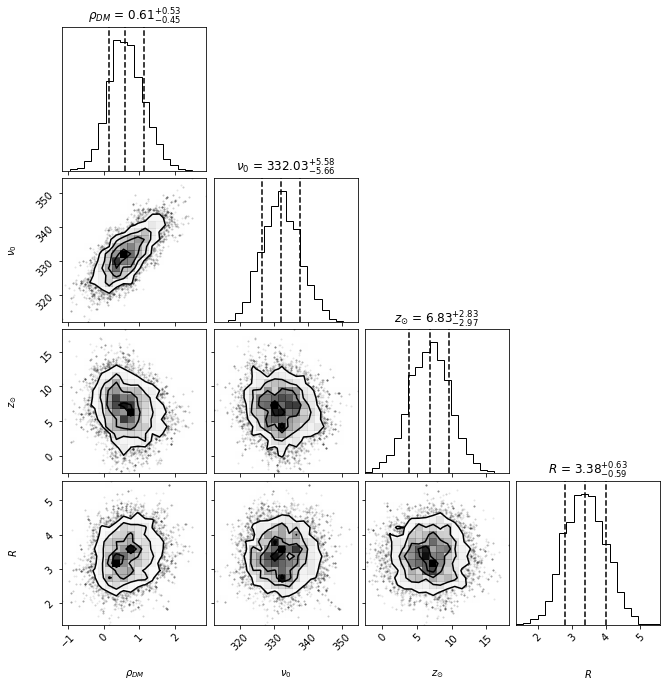

In [334]:
import corner

flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = flat_samples[:, 0]/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


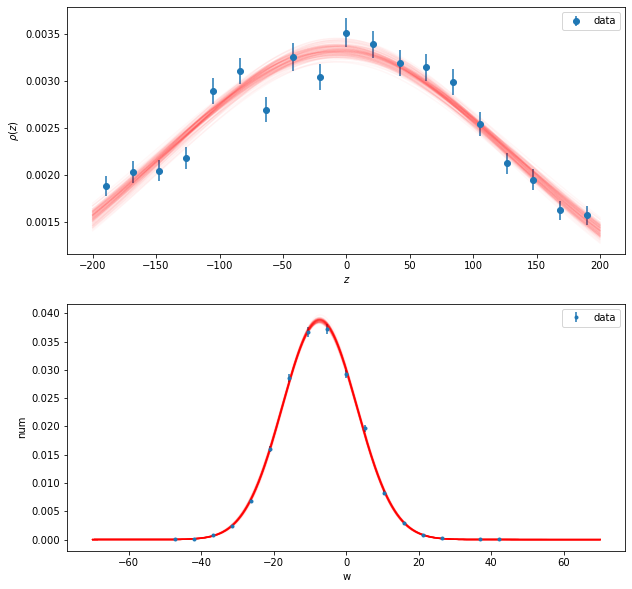

In [335]:
# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.03
zs = np.linspace(-200, 200, 100)
ws = np.linspace(-70, 70, 1000)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(100)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=flat_samples[index, 0],
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

# all at once

100%|██████████| 1000/1000 [00:30<00:00, 32.27it/s]


Multiprocessing took 31.1 seconds


100%|██████████| 2000/2000 [01:01<00:00, 32.41it/s]


Multiprocessing took 61.8 seconds


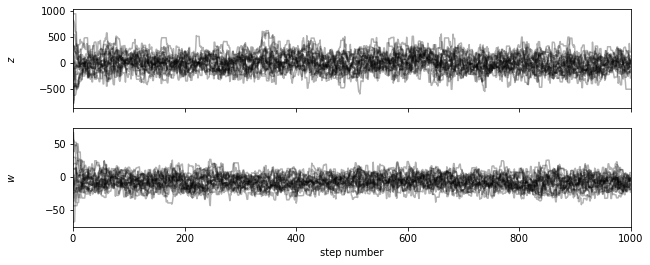

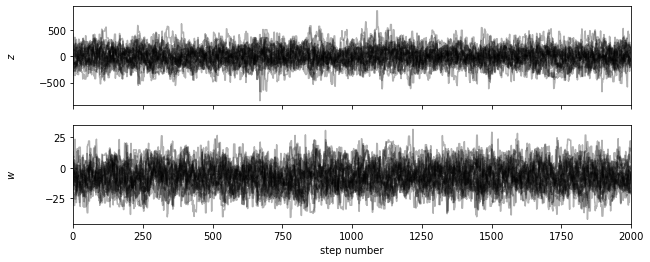

In [36]:
import emcee
import os
from multiprocessing import Pool
from time import time

rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 0 # Msun/pc^2
hDD = 1 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -0
sigma_w = np.array([10])
a_raw = np.array([1])
w0 = np.array([-7])

z = np.linspace(-1000, 1000, 200)
w = np.linspace(-70, 70, 200)

W, Z = np.meshgrid(w, z)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

FZW = fzw(Z, W, **theta)

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

ndim = 2
nwalkers = 20
z_0 = np.random.uniform(-1000, 1000, nwalkers)
w_0 = np.random.uniform(-70, 70, nwalkers)
p0 = np.array([z_0, w_0]).T

labels = [r"$z$", r"$w$"]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_prob, 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(p0, 1000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,4))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_prob, 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,4))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

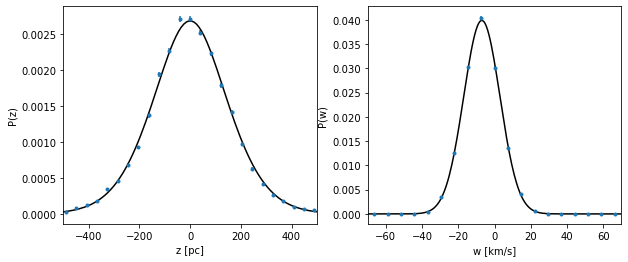

40000

In [37]:
flat_samples = sampler_.get_chain(flat=True).copy()
zs = flat_samples[:, 0]
ws = flat_samples[:, 1]

zbound = 500
wbound = 70

zedges = np.linspace(-1000, 1000, 50)
wedges = np.linspace(-70, 70, 20)

znum, _ = np.histogram(zs, bins=zedges)
wnum, _ = np.histogram(ws, bins=wedges)
zerr = np.sqrt(znum)
werr = np.sqrt(wnum)

zmid = (zedges[1:] + zedges[:-1]) / 2
wmid = (wedges[1:] + wedges[:-1]) / 2

areaz = np.trapz(znum, zmid)
areaw = np.trapz(wnum, wmid)

Fz = np.trapz(FZW, w, axis=1)
area = np.trapz(Fz, z)
Fz /= area
Fw = np.trapz(FZW, z, axis=0)
Fw /= area

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].errorbar(zmid, znum/areaz, yerr=zerr/areaz, fmt=".")
axes[0].plot(z, Fz, c="k")
axes[0].set_xlim(-zbound, zbound)
axes[0].set_xlabel("z [pc]")
axes[0].set_ylabel("P(z)")
axes[1].errorbar(wmid, wnum/areaw, yerr=werr/areaw, fmt=".")
axes[1].plot(w, Fw, c="k")
axes[1].set_xlim(-wbound, wbound)
axes[1].set_xlabel("w [km/s]")
axes[1].set_ylabel("P(w)")
plt.show()

znum.sum()

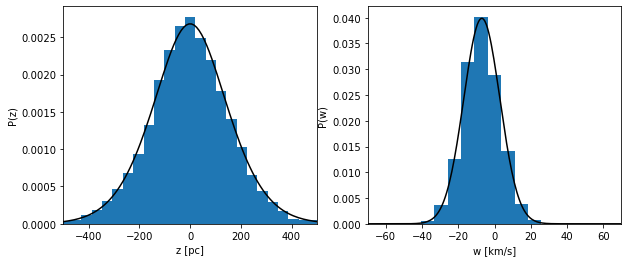

In [39]:
zs_filt = np.random.choice(zs, 10000, replace=False)
ws_filt = np.random.choice(ws, 10000, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(zs_filt, bins=zedges, density=True)
axes[0].plot(z, Fz, c="k")
axes[0].set_xlim(-zbound, zbound)
axes[0].set_xlabel("z [pc]")
axes[0].set_ylabel("P(z)")
axes[1].hist(ws_filt, bins=wedges, density=True)
axes[1].plot(w, Fw, c="k")
axes[1].set_xlim(-wbound, wbound)
axes[1].set_xlabel("w [km/s]")
axes[1].set_ylabel("P(w)")
plt.show()

100%|██████████| 500/500 [00:30<00:00, 16.53it/s]


Multiprocessing took 30.4 seconds


100%|██████████| 2000/2000 [01:59<00:00, 16.72it/s]


Multiprocessing took 119.7 seconds


100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


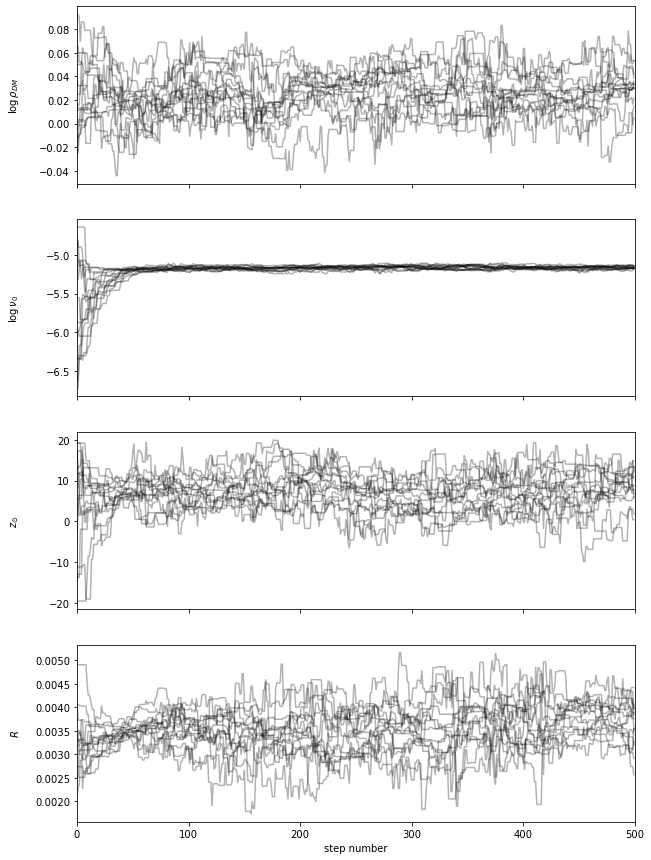

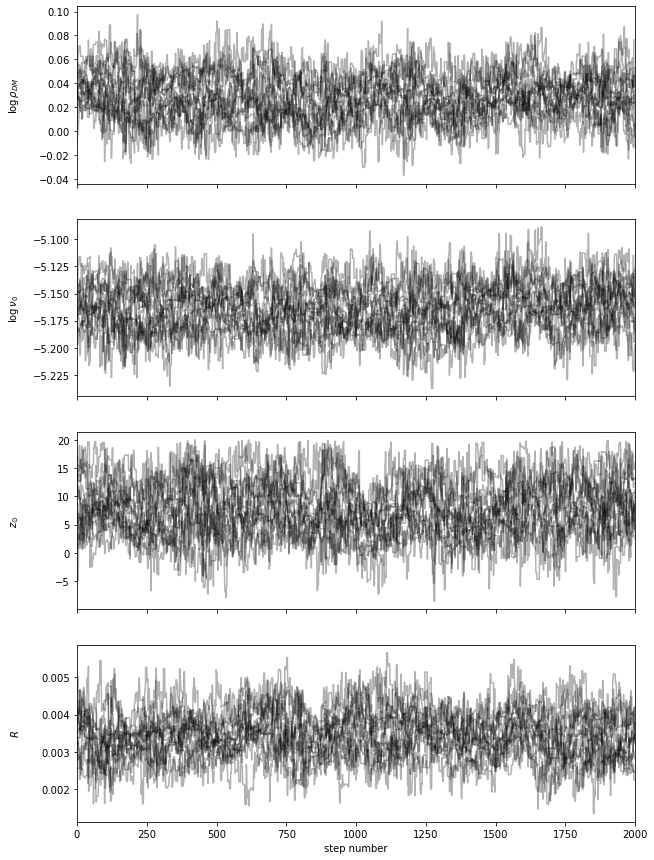

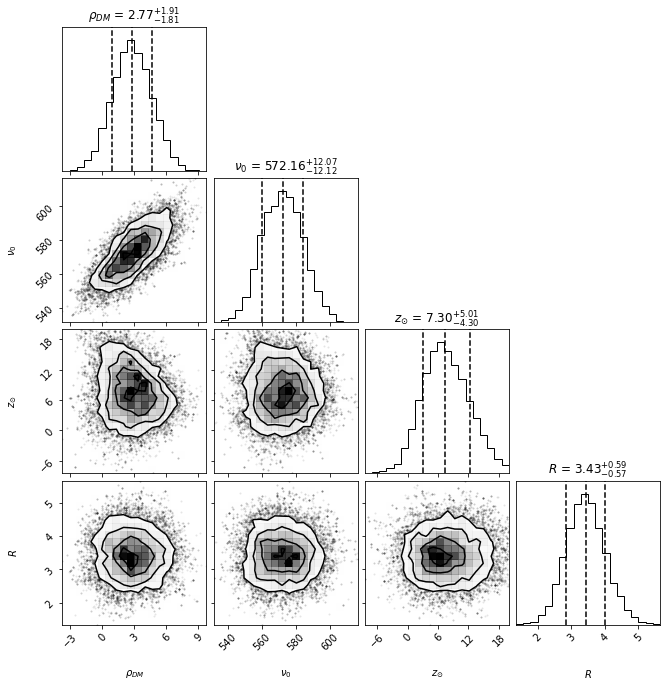

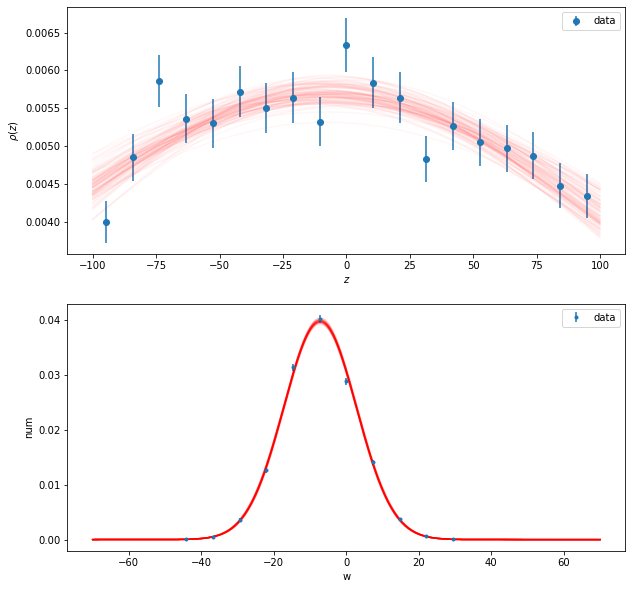

100%|██████████| 500/500 [00:31<00:00, 15.72it/s]


Multiprocessing took 31.9 seconds


100%|██████████| 2000/2000 [02:06<00:00, 15.87it/s]


Multiprocessing took 126.2 seconds


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


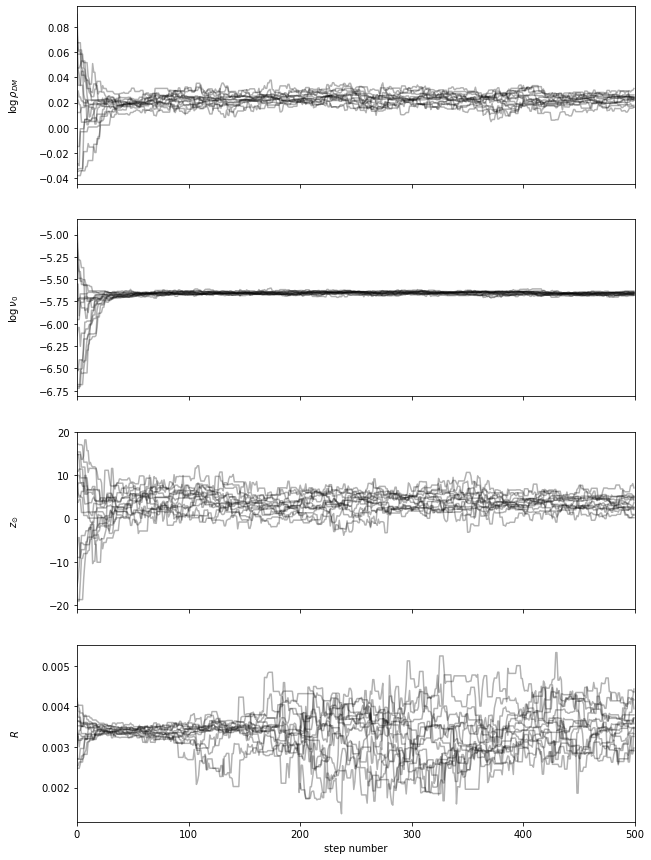

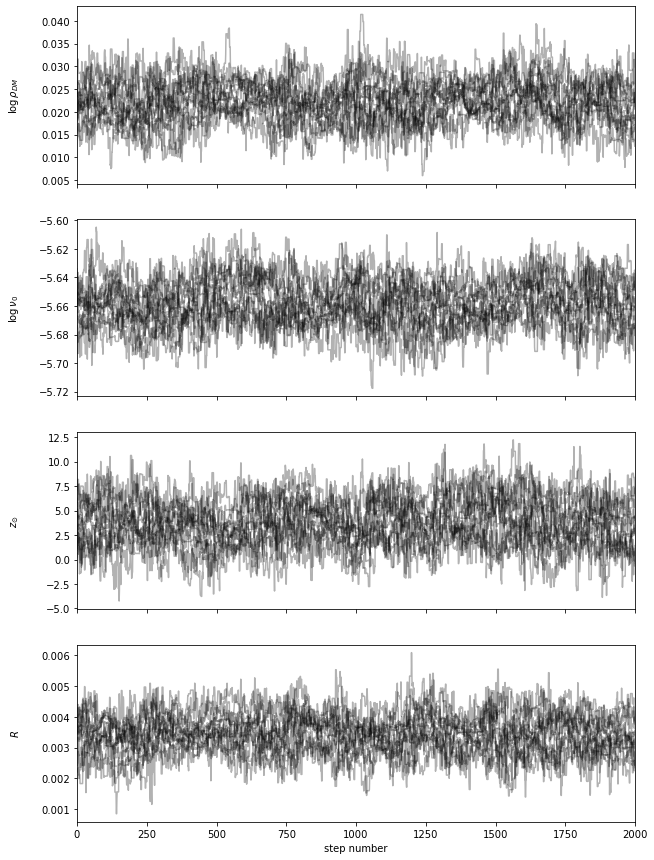

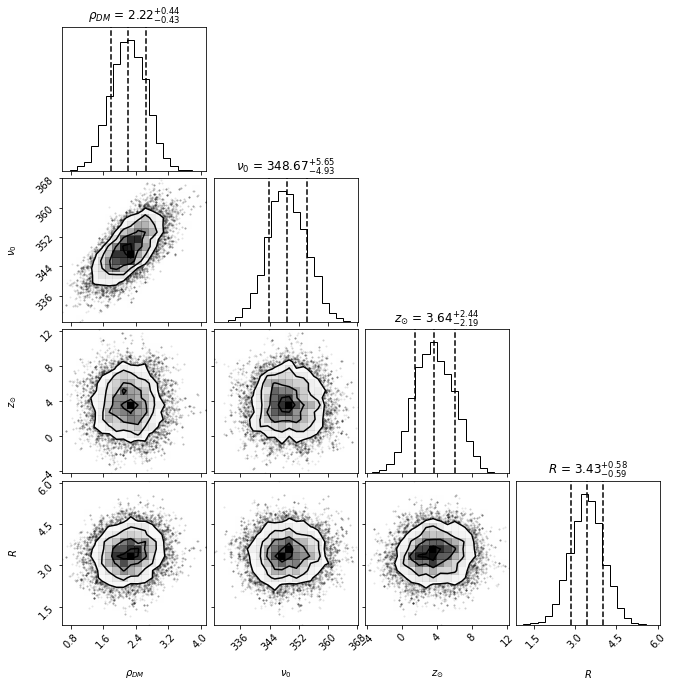

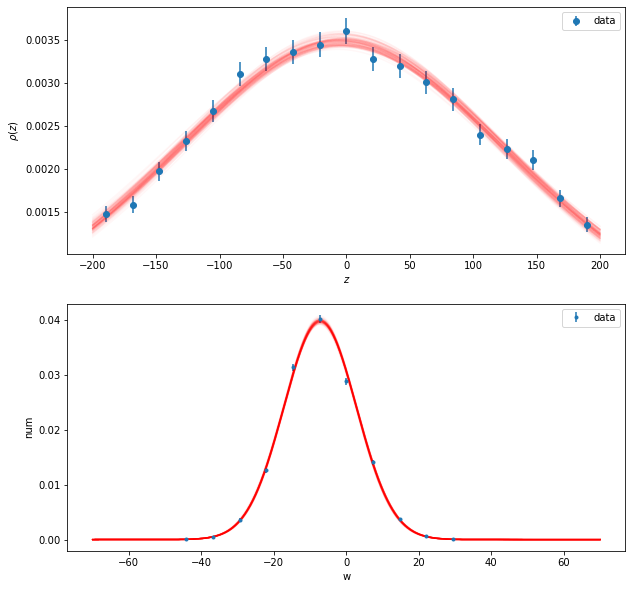

100%|██████████| 500/500 [00:33<00:00, 14.95it/s]


Multiprocessing took 33.6 seconds


100%|██████████| 2000/2000 [02:11<00:00, 15.18it/s]


Multiprocessing took 131.9 seconds


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


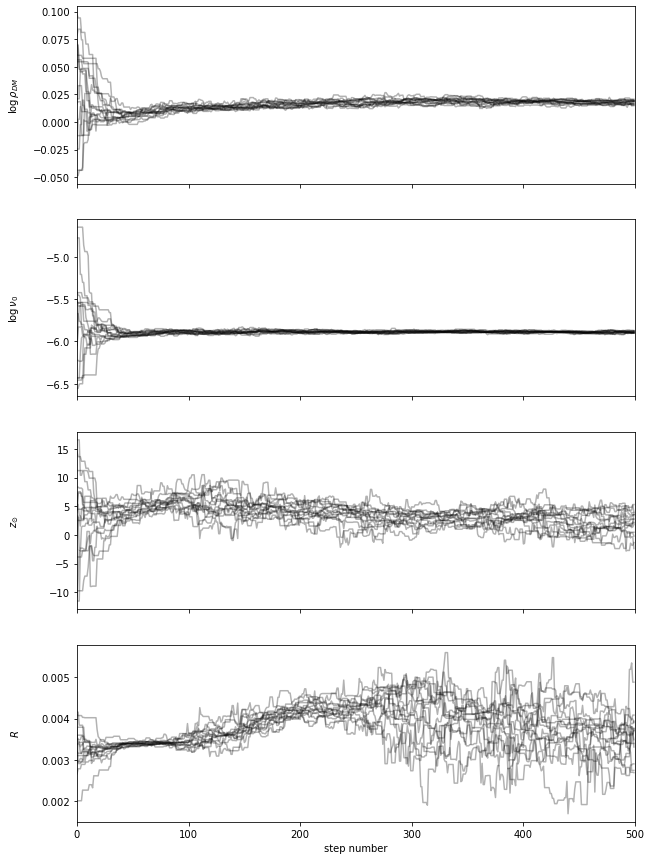

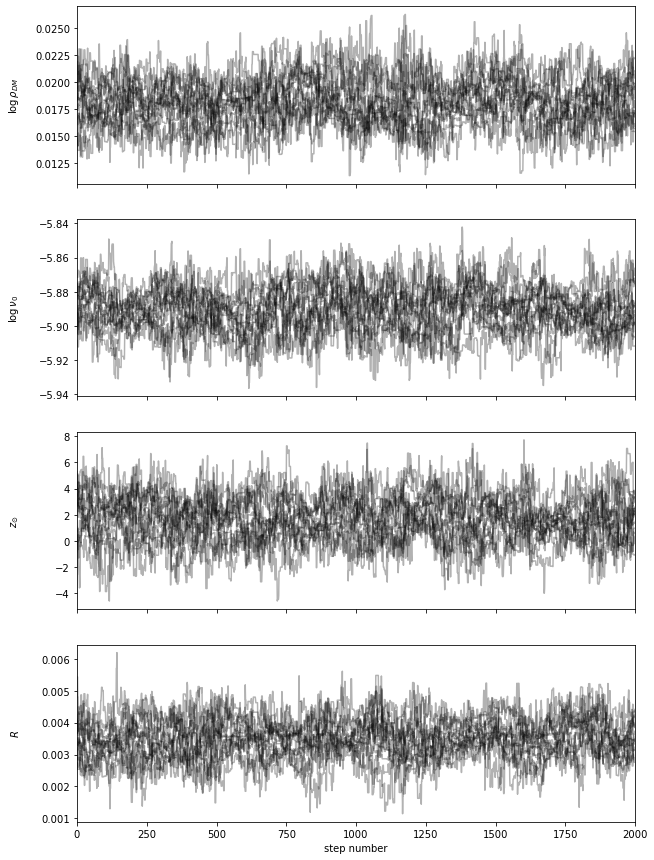

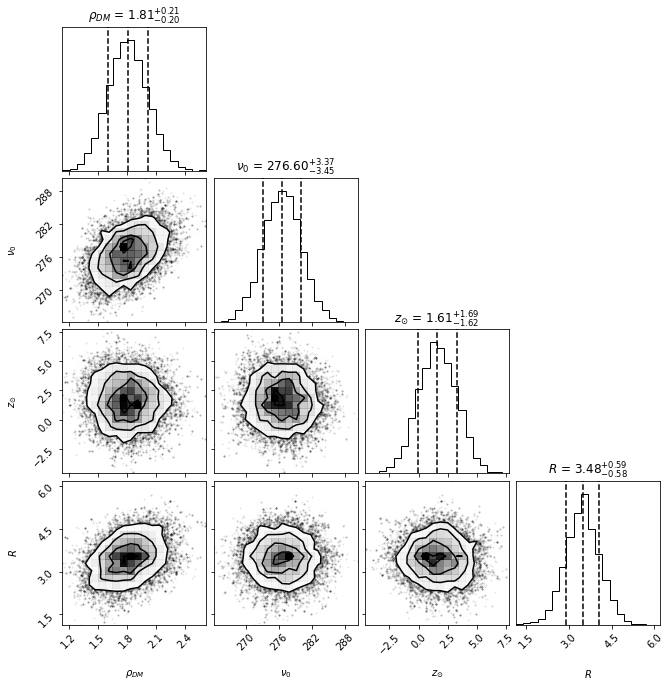

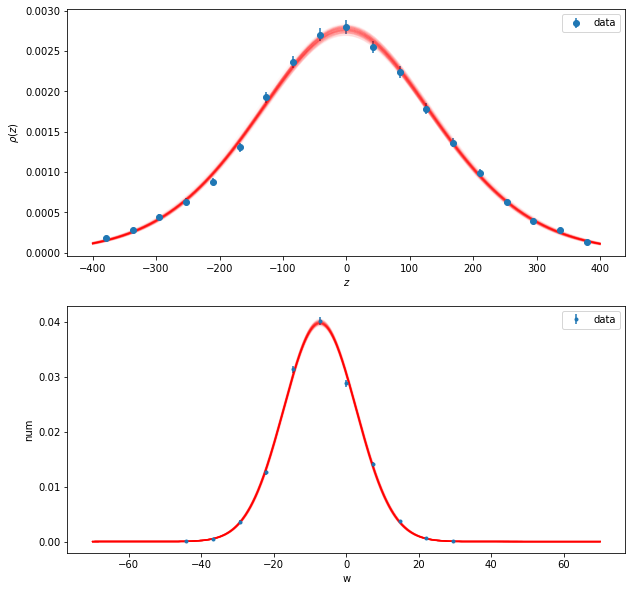

100%|██████████| 500/500 [00:34<00:00, 14.50it/s]


Multiprocessing took 34.6 seconds


100%|██████████| 2000/2000 [02:17<00:00, 14.59it/s]


Multiprocessing took 137.2 seconds


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


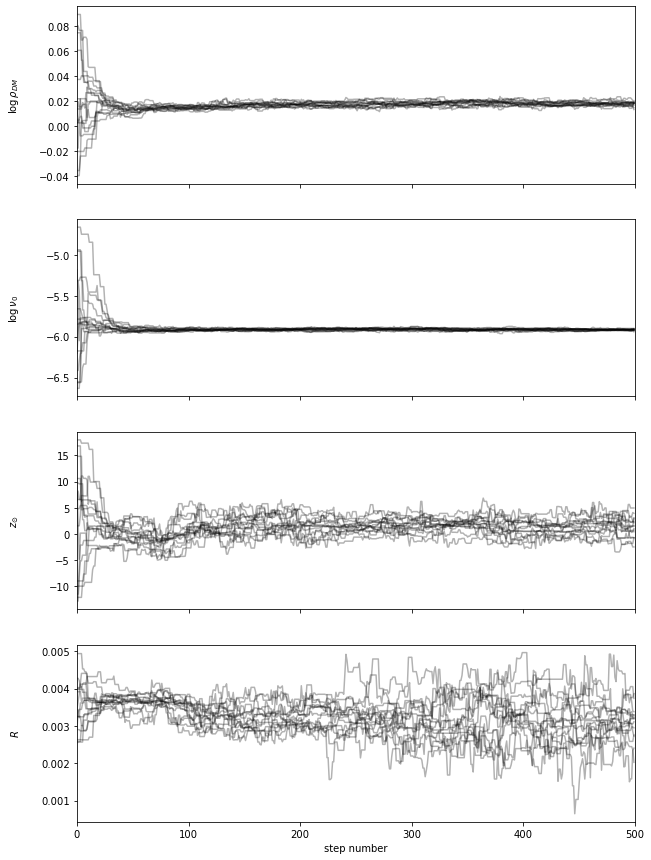

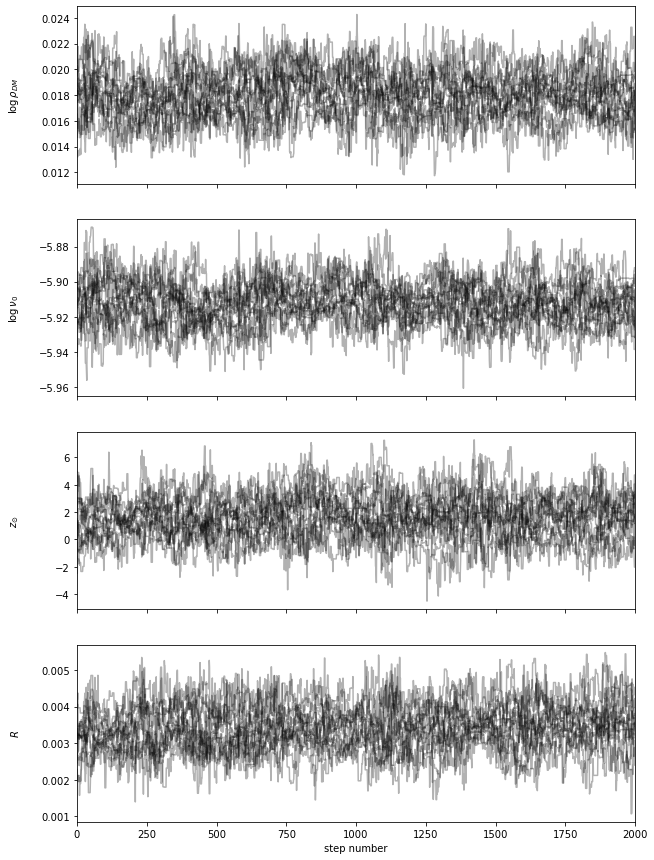

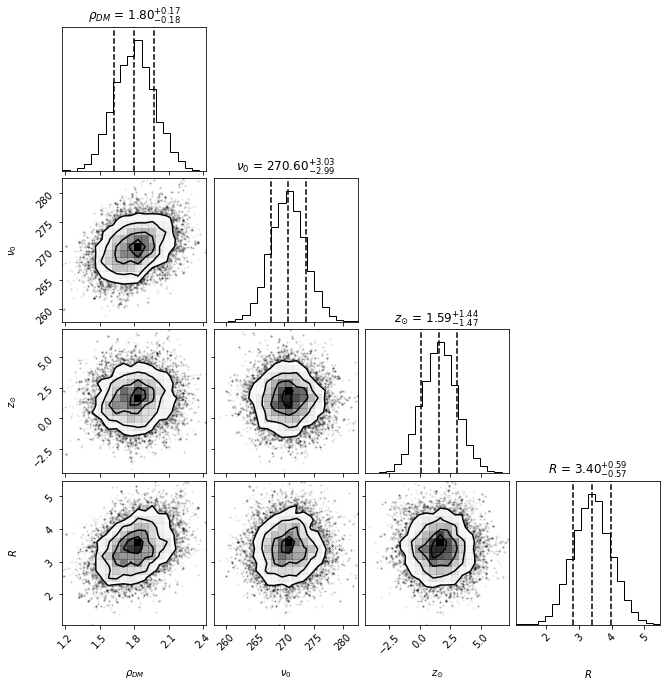

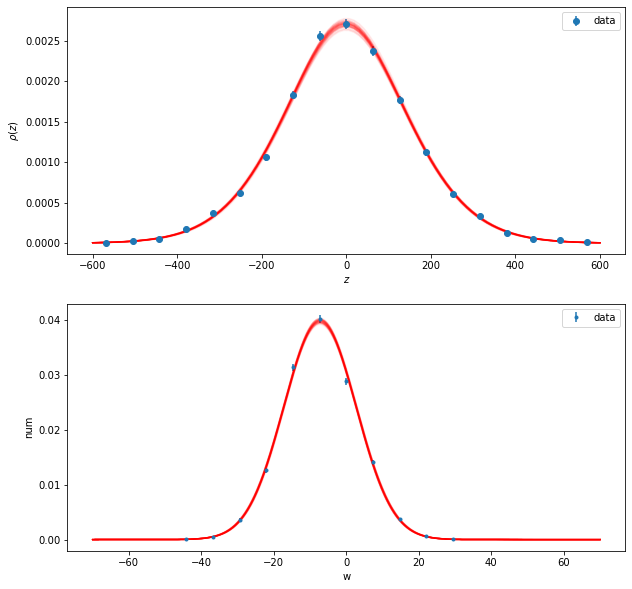

100%|██████████| 500/500 [00:34<00:00, 14.37it/s]


Multiprocessing took 34.9 seconds


100%|██████████| 2000/2000 [02:18<00:00, 14.45it/s]


Multiprocessing took 138.5 seconds


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


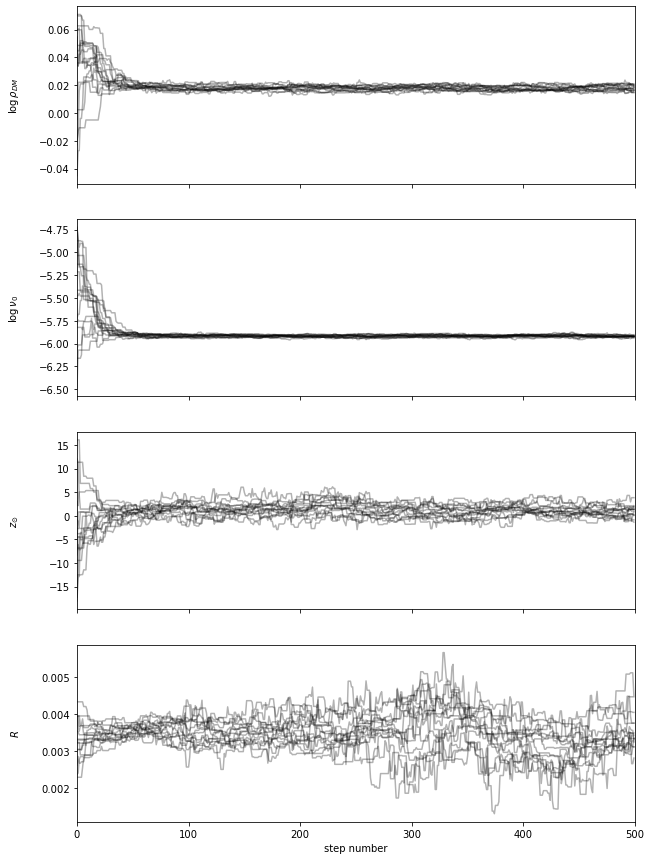

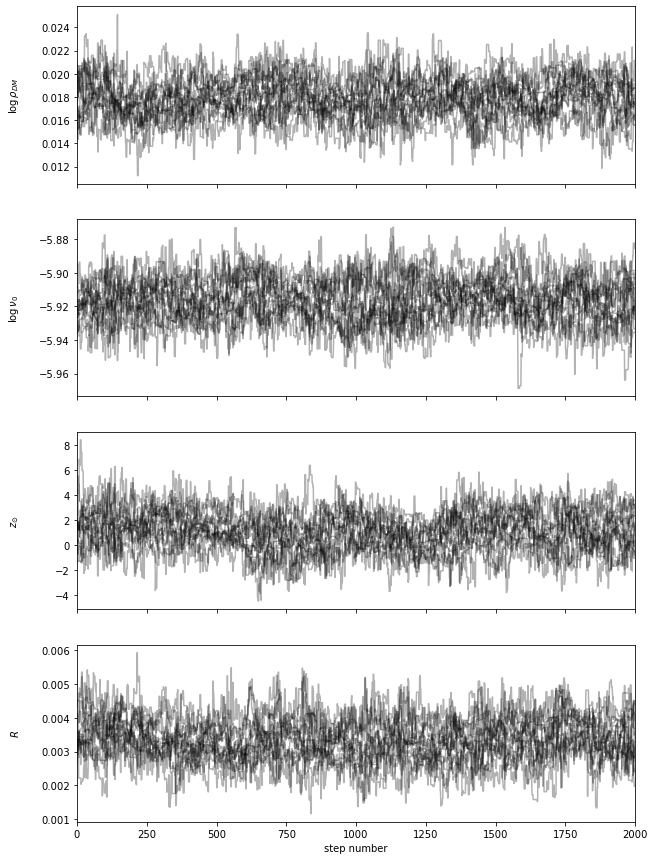

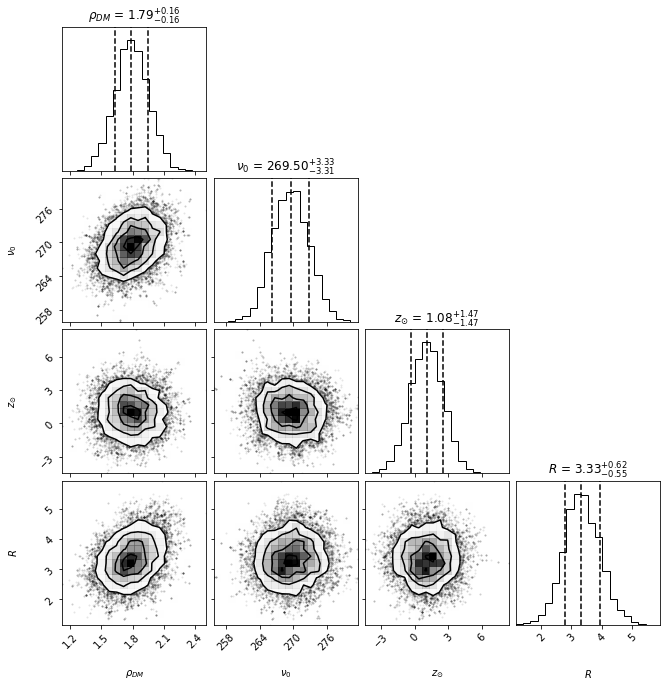

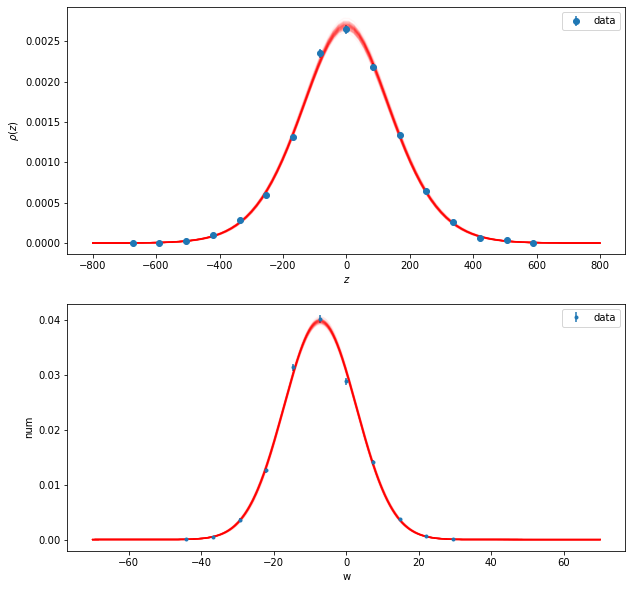

100%|██████████| 500/500 [00:35<00:00, 14.26it/s]


Multiprocessing took 35.2 seconds


100%|██████████| 2000/2000 [02:21<00:00, 14.13it/s]


Multiprocessing took 141.7 seconds


100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


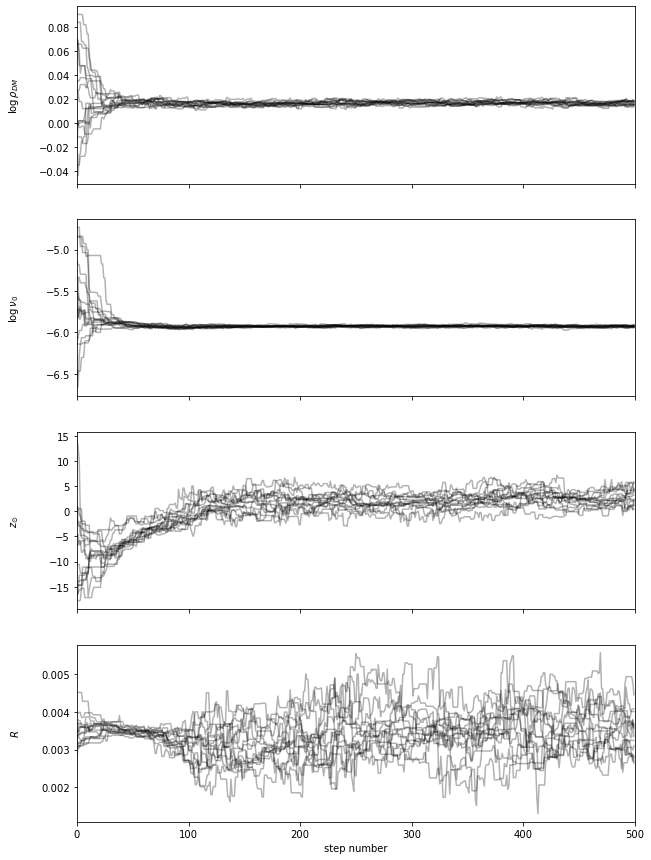

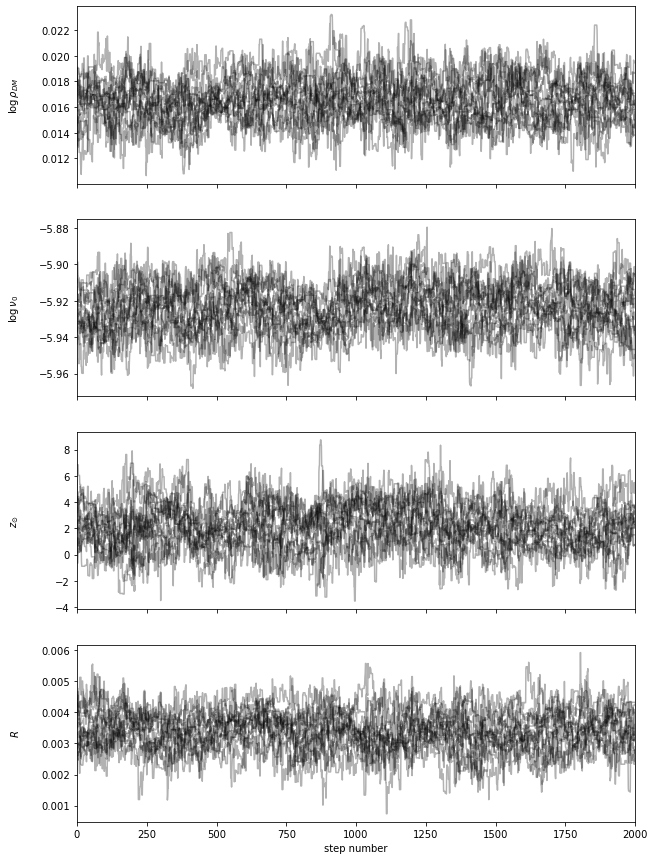

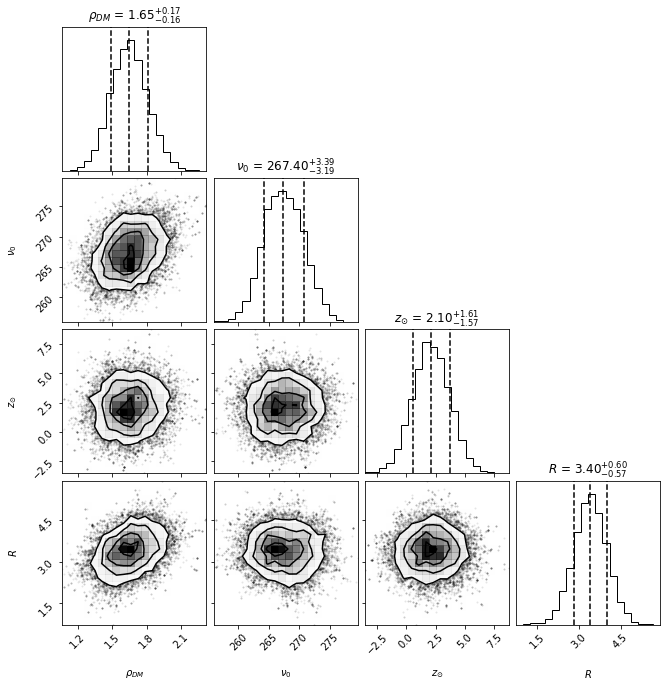

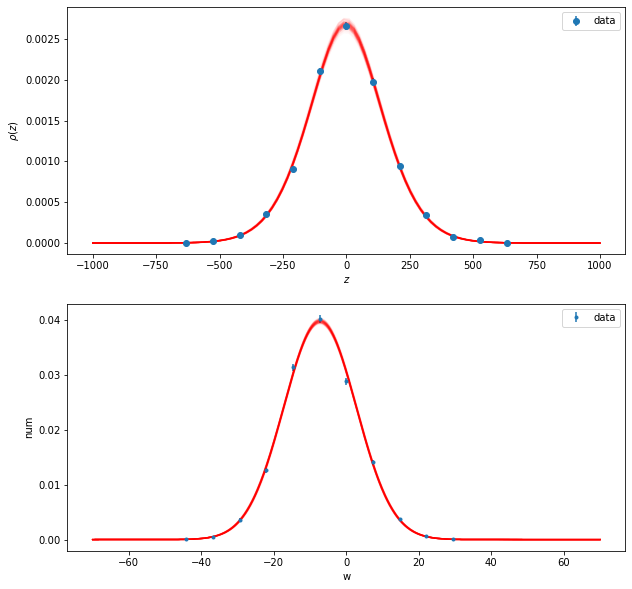

In [40]:
import corner

zbounds = [100, 200, 400, 600, 800, 1000]
wbound = 70
rhoDMs = []
for zbound in zbounds:
    zedges = np.linspace(-zbound, zbound, 20)
    wedges = np.linspace(-wbound, wbound, 20)

    zss = zs_filt[(zs_filt>-zbound) * (zs_filt<zbound)]
    wss = ws_filt[(ws_filt>-wbound) * (ws_filt<wbound)]

    znum, _ = np.histogram(zss, bins=zedges)
    wnum, _ = np.histogram(wss, bins=wedges)
    zerr = np.sqrt(znum)
    werr = np.sqrt(wnum)

    zmid = (zedges[1:] + zedges[:-1]) / 2
    wmid = (wedges[1:] + wedges[:-1]) / 2

    areaw = np.trapz(wnum, wmid)
    areaz = np.trapz(znum, zmid)

    zdens, wdens = znum/areaz, wnum/areaw
    zerr, werr = zerr/areaz, werr/areaw

    maskz = zdens>0
    maskw = wdens>0

    zdens, zerr, zmid = zdens[maskz], zerr[maskz], zmid[maskz]
    wdens, werr, wmid = wdens[maskw], werr[maskw], wmid[maskw]
    # dm only
    theta = [
        -0.01, 
        np.log(0.001), 
        10, 
        R, 
        w0, 
        np.log(sigma_w), 
        a_raw
    ]
    # flatten the list
    theta = np.concatenate([np.ravel(x) for x in theta])

    locs = dict(
        rhoDM=-0.05, 
        log_nu0=np.log(0.001), 
        zsun=-20, 
        R=R, 
        w0=w0-5, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
    )

    scales = dict(
        rhoDM=0.1-locs['rhoDM'],
        log_nu0=np.log(0.01)-locs['log_nu0'], 
        zsun=20-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(10, 1), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )

    zdata = (zmid, zdens, zerr)
    wdata = (wmid, wdens, werr)

    uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R']

    dim = 1

    theta = np.concatenate([np.ravel(x) for x in locs.values()])

    ndim = len(theta)
    nwalkers = ndim*2+1
    pars_list = uni_list_DM + norm_list_DM
    index = 0

    rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T

    os.environ["OMP_NUM_THREADS"] = "16"
    sampler_ = 0

    labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
    data = (zdata, wdata)
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_posterior_simple_DM, 
            args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
            pool=pool
        )
        start = time()
        state = sampler.run_mcmc(p0, 500, progress=True)
        samples = sampler.get_chain()
        end = time()
        multi_time = end - start
        plot_chain(samples, labels, figsize=(10,15))
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        sampler_ = sampler

        next_p0 = sampler_.get_chain()[-1]
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_posterior_simple_DM, 
            args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
            pool=pool
        )
        start = time()
        state = sampler.run_mcmc(next_p0, 2000, progress=True)
        samples = sampler.get_chain()
        end = time()
        multi_time = end - start
        plot_chain(samples, labels, figsize=(10,15))
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        sampler_ = sampler

    flat_samples = sampler_.get_chain(flat=True).copy()
    flat_samples = flat_samples[:, :4]
    flat_samples[:, 0] = flat_samples[:, 0]/1E-2
    flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
    flat_samples[:, 3] = flat_samples[:, 3]/1E-3


    labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]

    labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
    fig = corner.corner(
        flat_samples, labels=labels_2,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 12},
    )

    # plot two subplot
    flat_samples = sampler_.get_chain(flat=True).copy()
    alpha=0.03
    zs = np.linspace(-zbound, zbound, 100)
    ws = np.linspace(-wbound, wbound, 1000)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\rho(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'num')
    axes[1].legend()
    for i in tqdm(range(100)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhos=rhos, 
            sigmaz=sigmaz, 
            rhoDM=flat_samples[index, 0],
            sigmaDD=0, 
            hDD=1, 
            nu0=np.exp(flat_samples[index, 1]),
            zsun=flat_samples[index, 2],
            R=flat_samples[index, 3],
            w0=flat_samples[index, 4:4+dim],
            sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
            a=flat_samples[index, 4+2*dim:4+3*dim]
        )
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    plt.show()
    rhoDMs.append(flat_samples[:, 0])

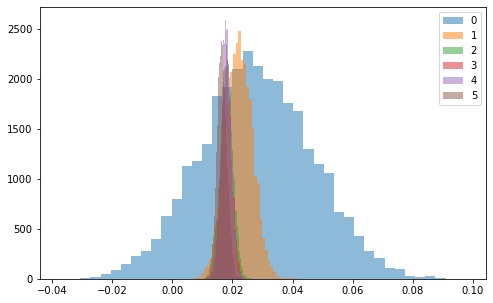

In [41]:
plt.figure(figsize=(8, 5))
for i, rhoDM in enumerate(rhoDMs):
    plt.hist(rhoDM, bins=40, alpha=0.5, label=i)
plt.legend()
plt.show()